In [1]:
from utils import *

In [10]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
paths = np.load('src/all_not_ext_paths_with_ids.npy')

In [3]:
result = []
frames = []

for curr_time in range(100, 120000, 200):

    time_before = np.arange(curr_time, curr_time - 5 * 20, -20)[::-1]
    time_after = np.arange(curr_time, curr_time + 6 * 20, 20)[1:]
    
    pedestrians_in_scene = paths[(paths[:,1] >= time_before[0])*(paths[:,1] <= time_after[-1])]
    
    tmp = np.bincount(pedestrians_in_scene[:,0])
    ind = np.nonzero(tmp)[0]
    frame_per_pedestrian = np.vstack((np.unique(pedestrians_in_scene[:,0]), tmp[ind])).T
    
    if frame_per_pedestrian.shape[0] != 0:
        result.append(np.count_nonzero(frame_per_pedestrian[:,1] != 10) / frame_per_pedestrian.shape[0] * 100)
        frames.append(curr_time)
        
labels = np.array(result)
frames = np.array(frames)

labels = (labels / 8).astype(int)

For each tenth frame we store in result (labels) a percent of pedestrians in that frame which are NOT in all ten nearest frames.

In original labels the least populated class has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2 to use stratified shuffle split so let's join some classes.

In [4]:
from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(labels, test_size=1/6, n_iter=1)

for train, test in sss:
    train_indices = train
    test_indices = test

In [5]:
category = np.empty_like(frames, dtype=object)
category[train_indices] = 'train'
category[test_indices] = 'test'

Let's check that mean values in all selection, in train and in test are the same.

In [6]:
labels.mean(), labels[train_indices].mean(), labels[test_indices].mean()

(5.8706896551724137, 5.873180873180873, 5.858585858585859)

In [12]:
data = pd.DataFrame({'frame_number': pd.Series(frames, index=range(frames.shape[0])),
                     'category': pd.Series(category, index=range(frames.shape[0])),
                     'label': pd.Series(labels, index=range(frames.shape[0]))})

In [13]:
data.to_csv('src/test_train_separation_by_frame.csv')

In [15]:
test_by_labels = data[data['category'] == 'test'].groupby(['label'])['label'].count()
train_by_labels = data[data['category'] == 'train'].groupby(['label'])['label'].count()

In [27]:
test_by_labels_normalized = test_by_labels.reindex(range(13)) / len(test_indices) * 100
train_by_labels_normalized = train_by_labels.reindex(range(13)) / len(train_indices) * 100

In [28]:
test_by_labels_normalized[test_by_labels_normalized.isnull()] = 0
train_by_labels_normalized[train_by_labels_normalized.isnull()] = 0

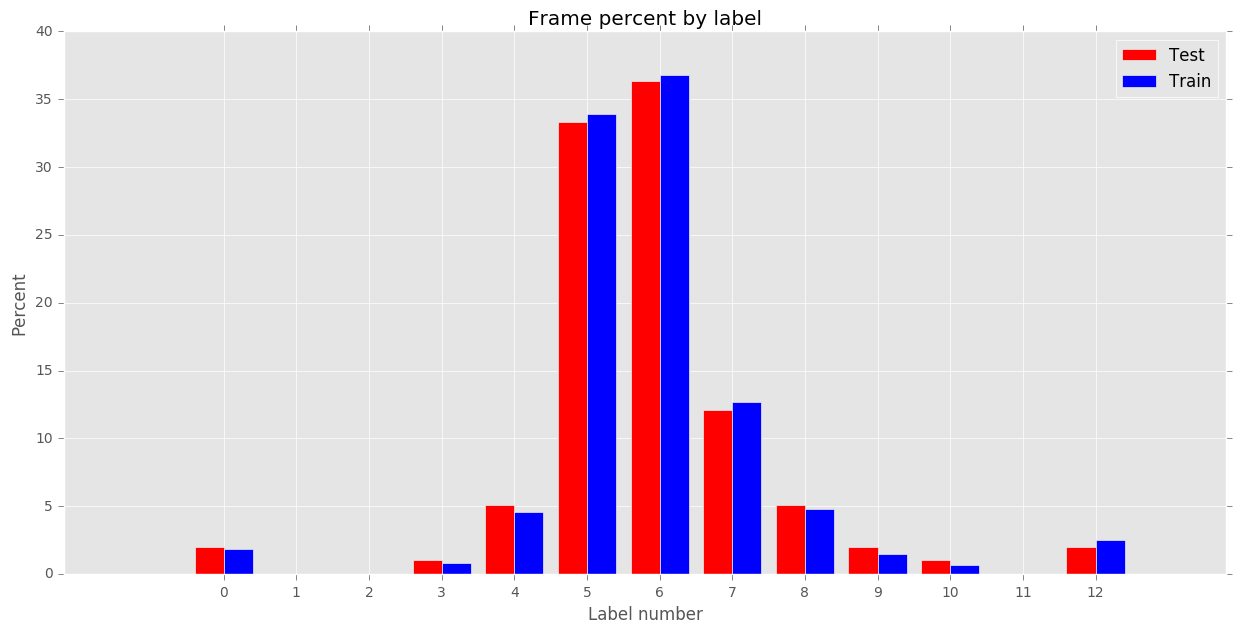

In [33]:
ind = np.arange(13)
width = 0.4
test_bar = plt.bar(ind - width/2, test_by_labels_normalized, width, color='r')
train_bar = plt.bar(ind + width/2, train_by_labels_normalized, width, color='b')

plt.ylabel('Percent')
plt.xlabel('Label number')
plt.title('Frame percent by label')
plt.xticks(ind + width/2., range(13))
plt.legend((test_bar[0], train_bar[0]), ('Test', 'Train'))
#plt.savefig('src/Plots/170221_frames_separation_percent_by_label.png')